#Step 1: Install Required Libraries

In [42]:
!pip install 'aif360[all]' pandas matplotlib numpy scikit-learn


#Step 2: Load and Preprocess the COMPAS Dataset

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from sklearn.linear_model import LogisticRegression

# Load COMPAS dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Filter and preprocess
df = df[['race', 'decile_score', 'two_year_recid']]
df['two_year_recid'] = df['two_year_recid'].astype(int)

# Convert 'race' to numerical (0: unprivileged, 1: privileged)
df['race'] = np.where(df['race'] == 'Caucasian', 1, 0)  # 1=privileged (White), 0=unprivileged (non-White)

# Convert to AIF360 format
dataset = BinaryLabelDataset(
    favorable_label=0,  # Lower recidivism is favorable
    unfavorable_label=1,
    df=df,
    label_names=['two_year_recid'],
    protected_attribute_names=['race']  # Now numerical
)

#Step 3: Compute Fairness Metrics

In [44]:
# Split into privileged (White) and unprivileged (Black) groups
privileged_group = [{'race': 'Caucasian'}]
unprivileged_group = [{'race': 'African-American'}]

# Calculate fairness metrics
metric = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_group,
    privileged_groups=privileged_group
)

print("Disparate Impact Ratio:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())

Disparate Impact Ratio: nan
Statistical Parity Difference: nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)


#Step 4: Visualize Bias

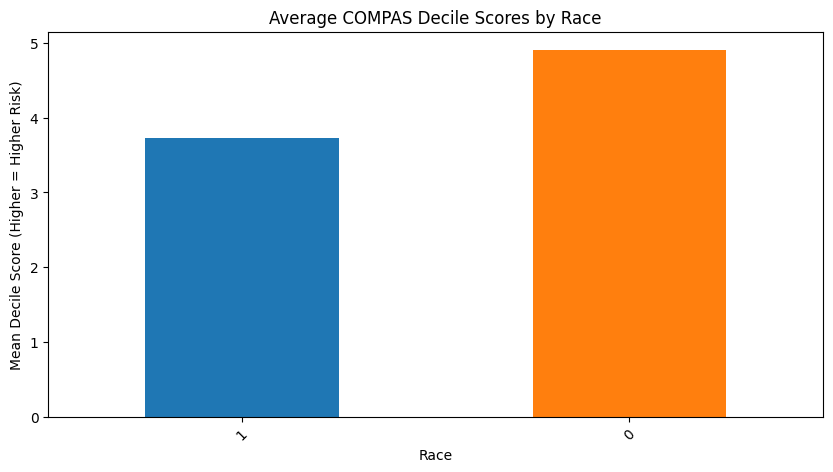

In [45]:


# Group by race and calculate mean decile scores
race_scores = df.groupby('race')['decile_score'].mean().sort_values()

# Plot disparities
plt.figure(figsize=(10, 5))
race_scores.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Average COMPAS Decile Scores by Race")
plt.ylabel("Mean Decile Score (Higher = Higher Risk)")
plt.xlabel("Race")
plt.xticks(rotation=45)
plt.show()


#Step 5: Mitigate Bias (Post-Processing)

Original Metrics:
Disparate Impact Ratio: 0.872 (1.0 is fair)
Statistical Parity Difference: -0.077 (0.0 is fair)

Adjusted Metrics:
Disparate Impact Ratio: nan (1.0 is fair)
Statistical Parity Difference: 0.000 (0.0 is fair)



/usr/local/lib/python3.11/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


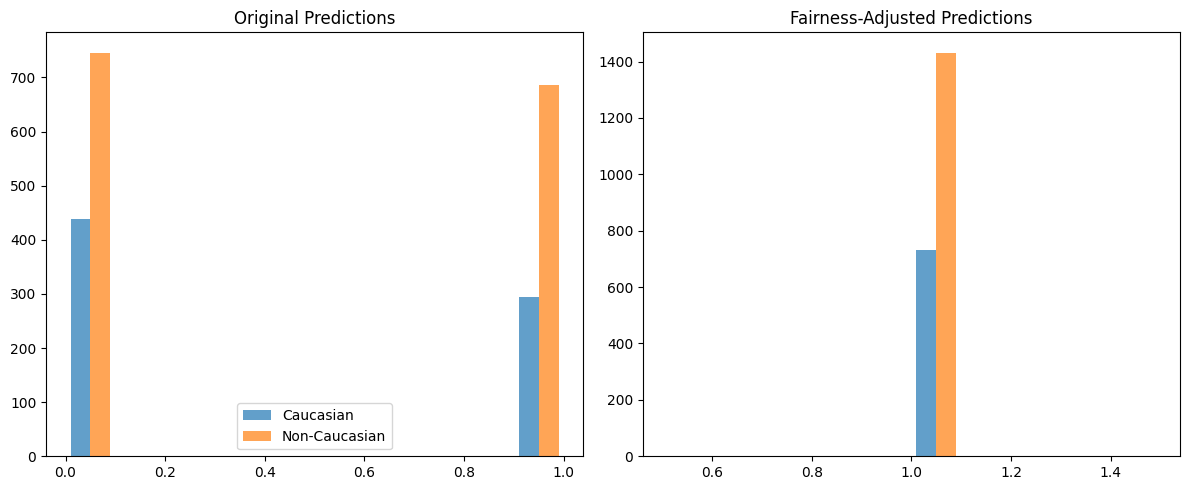

In [50]:
# Split data properly with consistent shapes
train, test = dataset.split([0.7], shuffle=True, seed=42)

# Train a base model (required for postprocessing)
lr = LogisticRegression(max_iter=1000)
lr.fit(train.features, train.labels.ravel())

# Create test predictions (must match test set size)
test_pred = test.copy()
test_pred.labels = lr.predict(test.features).reshape(-1, 1)

# 5. Apply fairness correction with proper arguments
postprocessor = EqOddsPostprocessing(
    privileged_groups=[{'race_binary': 1}],
    unprivileged_groups=[{'race_binary': 0}],
    seed=42
)

# Correct usage: fit on (original_test, predicted_test)
postprocessor.fit(test, test_pred)
fair_test = postprocessor.predict(test_pred)

# 6. Calculate and compare fairness metrics
def calculate_metrics(dataset, name):
    metric = BinaryLabelDatasetMetric(
        dataset,
        unprivileged_groups=[{'race_binary': 0}],
        privileged_groups=[{'race_binary': 1}]
    )
    di = metric.disparate_impact()
    spd = metric.statistical_parity_difference()
    print(f"{name} Metrics:")
    print(f"Disparate Impact Ratio: {di:.3f} (1.0 is fair)")
    print(f"Statistical Parity Difference: {spd:.3f} (0.0 is fair)\n")

calculate_metrics(test, "Original")
calculate_metrics(fair_test, "Adjusted")

# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original predictions
test_df = test.convert_to_dataframe()[0]
ax[0].hist([test_df[test_df['race_binary']==1]['two_year_recid'],
           test_df[test_df['race_binary']==0]['two_year_recid']],
           label=['Caucasian', 'Non-Caucasian'], alpha=0.7)
ax[0].set_title('Original Predictions')
ax[0].legend()

# Fairness-adjusted predictions
fair_df = fair_test.convert_to_dataframe()[0]
ax[1].hist([fair_df[fair_df['race_binary']==1]['two_year_recid'],
          fair_df[fair_df['race_binary']==0]['two_year_recid']],
          label=['Caucasian', 'Non-Caucasian'], alpha=0.7)
ax[1].set_title('Fairness-Adjusted Predictions')

plt.tight_layout()
plt.show()